# compare called samples in olink augmented models

In [1]:
from pineapple.contrib.results.results_loader import load_results
from collections import Counter
import numpy as np

### 26 prot model

In [2]:
bucket = 'freenome-user-data-bgould'
dir_path = 'olink2/dc1_dc2a_minus_pre_post_aa_neg_olink_24_prot_combat'
 
test_results = load_results(f'{bucket}', f'{dir_path}')

In [3]:
df_prot24_res = test_results[2]
df_prot24_res.head()

,fold,label,score,sample_id,metadata,prediction
0,metadata_balanced_kfold_stage_6,0,"[0.5206717247293325, 0.47932827527066746]",13313,CalzoneSampleMetadata(raw_sample_metadata={'li...,0
1,metadata_balanced_kfold_stage_6,0,"[0.8464857317232187, 0.15351426827678125]",13756,CalzoneSampleMetadata(raw_sample_metadata={'li...,0
2,metadata_balanced_kfold_stage_6,0,"[0.7341630650835508, 0.2658369349164492]",13826,CalzoneSampleMetadata(raw_sample_metadata={'li...,0
3,metadata_balanced_kfold_stage_6,0,"[0.4799609917067862, 0.5200390082932138]",13904,CalzoneSampleMetadata(raw_sample_metadata={'li...,1
4,metadata_balanced_kfold_stage_6,0,"[0.8058386725542237, 0.19416132744577627]",13926,CalzoneSampleMetadata(raw_sample_metadata={'li...,0


### 3 prot model

In [4]:
bucket = 'freenome-user-data-bgould'
dir_path = 'olink_beta/dc2-beta-readout_3protein_model_MMP7_trained_dc2a_dc1j_AA_CRC_with_frozen_combat'
 
test_results = load_results(f'{bucket}', f'{dir_path}')
df_prot3_res = test_results[2]


In [31]:
txt_labels = [d.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"] for d in df_prot3_res["metadata"]]
Counter(txt_labels)

Counter({'Colorectal Normal / Healthy': 2160,
         'Colorectal Pre-Cancer': 328,
         'Colorectal Cancer': 252})

In [32]:
keep = [ lbl != "Colorectal Cancer" for lbl in txt_labels]
df_prot3_res_f = df_prot3_res[keep]
print(df_prot3_res.shape)
print(df_prot3_res_f.shape)

(2740, 6)
(2488, 6)


### 2 prot model

In [7]:
bucket = 'freenome-user-data-bgould'
dir_path = 'olink2/dc1_dc2a_minus_pre_post_aa_neg_olink_2_prot_combat'
 
test_results = load_results(f'{bucket}', f'{dir_path}')
df_prot2_res = test_results[2]

txt_labels = [d.raw_sample_metadata["lims_top_diagnosis"]["cancer_type"] for d in df_prot2_res["metadata"]]
Counter(txt_labels)

Counter({'Colorectal Normal / Healthy': 2580, 'Colorectal Pre-Cancer': 355})

### merge three outputs

In [8]:
def maj_vote_table(df):
    #sids = list(set(df.sample_id))
    #print(sids[0:5])
    sid_to_final = {}

    for name,sub_df in df.groupby("sample_id"):
        true = sub_df.iloc[0,1]
        if list(sub_df.prediction).count(1) >=3:
            final = 1
        else:
            final = 0
        sid_to_final[name]=(true,final)
    
    return sid_to_final
            

In [9]:
prot2_sid_to_final = maj_vote_table(df_prot2_res)
#prot2_sid_to_final.items()

In [37]:
prot3_sid_to_final = maj_vote_table(df_prot3_res_f)

In [11]:
prot24_sid_to_final = maj_vote_table(df_prot24_res)

### all overlapping samples

In [17]:
from venn import venn
from matplotlib import pyplot as plt
%matplotlib inline



<Figure size 432x288 with 0 Axes>

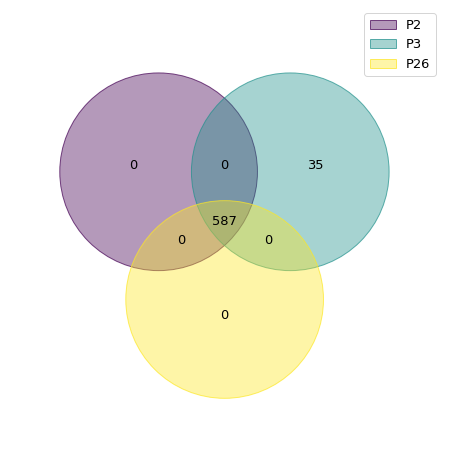

In [22]:
plt.figure()
venn({"P2":set(prot2_sid_to_final.keys()), "P3":set(prot3_sid_to_final.keys()), "P26":set(prot24_sid_to_final.keys())})




In [41]:
#remove non overlapping samples from p3
uniqs = [sid for sid in prot3_sid_to_final if sid not in prot2_sid_to_final.keys()]
for sid in uniqs:
    del prot3_sid_to_final[sid]
        
print(len(prot3_sid_to_final.items()))

587


## overlapping correct calls


Text(0.5, 1.0, 'Correct AA Calls for Olink Models')

<Figure size 432x288 with 0 Axes>

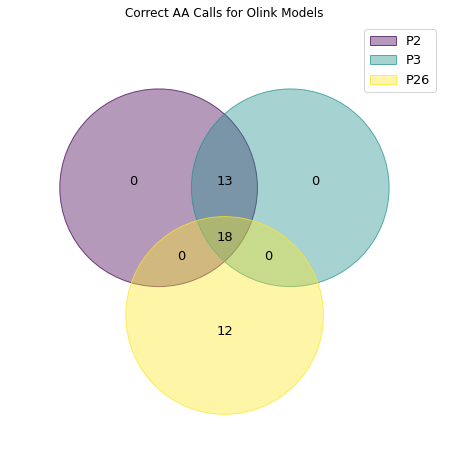

In [42]:
## correct positive calls
correct_p2_calls = [ sid for sid,calls in prot2_sid_to_final.items() if calls[0]==calls[1]==1]
correct_p3_calls = [ sid for sid,calls in prot3_sid_to_final.items() if calls[0]==calls[1]==1]
correct_p24_calls = [ sid for sid,calls in prot24_sid_to_final.items() if calls[0]==calls[1]==1]

plt.figure()
venn({"P2":set(correct_p2_calls), "P3":set(correct_p3_calls), "P26":set(correct_p24_calls)})
plt.title("Correct AA Calls for Olink Models")

Text(0.5, 1.0, 'Correct Healthy Calls for Olink Models')

<Figure size 432x288 with 0 Axes>

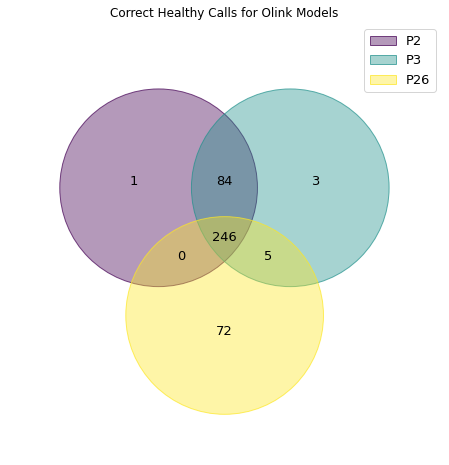

In [43]:
## correct negative calls
correct_p2_calls = [ sid for sid,calls in prot2_sid_to_final.items() if calls[0]==calls[1]==0]
correct_p3_calls = [ sid for sid,calls in prot3_sid_to_final.items() if calls[0]==calls[1]==0]
correct_p24_calls = [ sid for sid,calls in prot24_sid_to_final.items() if calls[0]==calls[1]==0]

plt.figure()
venn({"P2":set(correct_p2_calls), "P3":set(correct_p3_calls), "P26":set(correct_p24_calls)})
plt.title("Correct Healthy Calls for Olink Models")

In [12]:
df_prot24_res.loc[0,"metadata"]

CalzoneSampleMetadata(raw_sample_metadata={'lims_sample': {'secondary_id': '17510140', 'id': 13313, 'study_type': 'Prospective Clinical Study', 'collection_date': datetime.date(2018, 4, 16), 'collection_time': None, 'collection_time_end': None, 'age_at_blood_draw': 70, 'blood_draw_relative_to_tx': 'Pre-Colonoscopy', 'notes': None, 'sample_use': 'Standard', 'accession_date': '2018-04-17T23:45:31+00:00', 'validated_by': 'abe.tzou@freenome.com', 'validated_on': datetime.datetime(2018, 9, 26, 0, 29, 39, tzinfo=<UTC>), 'double_checked_by': None, 'double_checked_on': None, 'phlebotomist_initials': None, 'timing_confidence_level': 'Definite', 'protocol_version': None, 'num_tubes_in_freezer': 20, 'num_tubes_known_location': 14, 'num_plasma_tubes_known_location': 11, 'total_volume_remaining_ml': 8.06, 'total_plasma_volume_remaining_ml': 6.76, 'num_tubes_with_process': 0}, 'lims_patient': {'id': 18138, 'secondary_id': '17510140A', 'sex': 'Male', 'ethnicity_northern_european': True, 'ethnicity_so